# Analyis NLP
That’s what the data said: An NLP Analysis of Character Relationships and Speaking Styles in the US TV-Show “The Office”
That’s what the data said: An NLP Analysis of the Script of the US TV-Show “The Office”

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer

from preprocessing_nlp import preprocess, extract_features

PATH = "../data/"
FILE = "the-office-lines_scripts.csv"

In [43]:
df_raw = pd.read_csv(PATH+FILE, sep=",", index_col="id")
df_raw.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [3]:
param_dict = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": False, 
    "exp_contractions": False,
    "conversion": None
}

df = preprocess(df_raw, **param_dict)
df.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,101,NaN
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,101,NaN
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,101,NaN
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,101,NaN
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,101,NaN


In [4]:
char_app = df.sort_values(['season','episode','scene']).drop_duplicates(['season','episode','scene','speaker'],keep='first')
char_app_count = char_app.groupby(['speaker', 'season']).size().reset_index(name='counts')

char_app_count['season'] = char_app_count['season'].astype(str)

top_char = char_app.groupby(['speaker']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)['speaker'].iloc[:20]

#filter for top 20 characters
char_app_count_sorted = char_app_count[char_app_count['speaker'].isin(top_char)].sort_values(by=['season'])

fig = px.bar(char_app_count_sorted, x='speaker', y='counts', color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Scene appearances per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_char)


In [5]:
top20_characters = df["speaker"].value_counts().head(20).index.tolist()
lines_per_character = df[["speaker", "season", "line_text"]][df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).count().reset_index(level=[0,1])
lines_per_character['season'] = lines_per_character['season'].astype(str)
fig = px.bar(lines_per_character.sort_values("season"), x="speaker", y="line_text", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Lines per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of lines')

In [6]:
words_df = df.copy()
words_df['word_count'] = words_df['line_text'].apply(lambda x: len(x.split()))
top20_characters = words_df[["speaker", "word_count"]].groupby("speaker").sum().sort_values("word_count", ascending=False).index[:20]
words_per_character = words_df[["speaker", "season", "word_count"]][words_df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).sum().reset_index(level=[0,1])
words_per_character['season'] = words_per_character['season'].astype(str)

fig = px.bar(words_per_character.sort_values("season"), x="speaker", y="word_count", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Words per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of words')

In [7]:
speaker_list = ["Michael", "Dwight", "Jim", "Pam", "Andy"]

lines_per_speaker_episode = df.loc[df["speaker"].isin(speaker_list)].groupby(["speaker", "season_episode"]).count()["line_text"].unstack(fill_value=0).stack().reset_index(level=['speaker', 'season_episode']).sort_values("season_episode")
lines_per_speaker_episode.sort_values(["season_episode"], inplace=True)
lines_per_speaker_episode.rename(columns={0: "number of lines"}, inplace=True)

fig = px.line(lines_per_speaker_episode, x="season_episode", y="number of lines", color="speaker", title="Lines per speaker and episode")

fig.add_annotation(
    x=17
    , y=170
    , text=f'Andy is introduced'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=87.5
    , y=170
    , text=f'Birth of Jim and Pam\'s daughter'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=126.5
    , y=170
    , text=f'Michael leaves'
    , showarrow=False
    , align="left")

fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=28, x1=28,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=106, x1=106,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=135, x1=135,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                  ]                
                  )

fig.add_vrect(x0="170", x1="176", 
              annotation_text="Andy is on a boat trip", annotation_position="top right",  
              annotation_font_size=11,
              annotation_font_color="Blue",
              fillcolor="blue", opacity=0.25, line_width=0)

In [8]:
param_dict_tokens = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True)
}

df_tokens = preprocess(df_raw, **param_dict_tokens)
df_tokens.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[all, right, jim, your, quarterlies, look, ver...",Michael,101,NaN
2,1,1,1,"[oh, i, told, you, i, could, not, close, it, so]",Jim,101,NaN
3,1,1,1,"[so, you, have, come, to, the, master, for, gu...",Michael,101,NaN
4,1,1,1,"[actually, you, called, me, in, here, but, yeah]",Jim,101,NaN
5,1,1,1,"[all, right, well, let, me, show, you, how, it...",Michael,101,NaN


In [9]:
all_words =  [item for sublist in df_tokens["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

fig = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words')
fig.update_layout(yaxis_title='Word', xaxis_title='Frequency')

fig.show()


In [10]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": True,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True)
}

df_tokens_nostopwords = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_tokens_nostopwords.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[right, jim, quarterlies, look, good, things, ...",Michael,101,NaN
2,1,1,1,"[oh, told, could, close]",Jim,101,NaN
3,1,1,1,"[come, master, guidance, saying, grasshopper]",Michael,101,NaN
4,1,1,1,"[actually, called, yeah]",Jim,101,NaN
5,1,1,1,"[right, well, let, show, done]",Michael,101,NaN


In [11]:
all_words =  [item for sublist in df_tokens_nostopwords["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

fig2 = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words (after stopword removal)')
fig2.show()

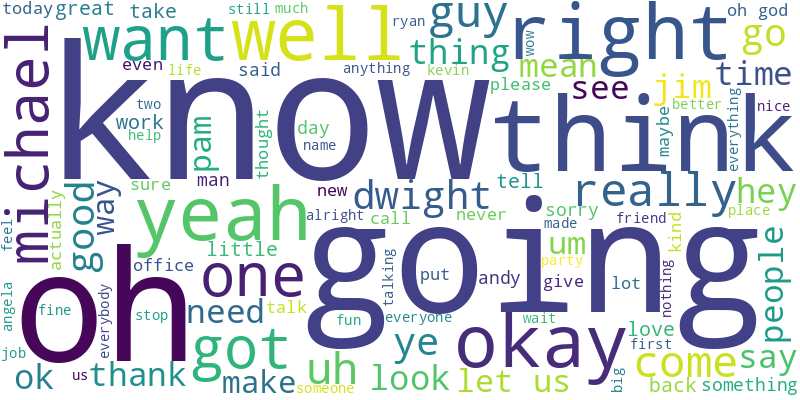

In [12]:
# create a wordcloud from all_words
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate(" ".join(all_words))
wordcloud.to_image()


In [13]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": True,
    "lwr": True, 
    "exp_contractions": True,
    "normalize": "lemmatize",
    "conversion": "pos_tag"
}

df_tokens_tagged = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_tokens_tagged.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[(right, RB), (jim, NN), (quarterly, JJ), (loo...",Michael,101,NaN
2,1,1,1,"[(oh, UH), (told, NN), (could, MD), (close, VB)]",Jim,101,NaN
3,1,1,1,"[(come, VBN), (master, NN), (guidance, NN), (s...",Michael,101,NaN
4,1,1,1,"[(actually, RB), (called, VBN), (yeah, NN)]",Jim,101,NaN
5,1,1,1,"[(right, RB), (well, RB), (let, VB), (show, VB...",Michael,101,NaN


In [14]:
# filter words by POS tag
all_words_tagged =  [item for sublist in df_tokens_tagged["line_text"].tolist() for item in sublist]
all_words_tagged_filtered = [item[0] for item in all_words_tagged if item[1] in ["NN"]]

In [15]:
param_dict_tokens_nostopwords = {
    "concat_scenes": True,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
}

df_concat_scenes = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_concat_scenes.head()

,season,episode,scene,line_text,season_episode,directionals
0,1,1,1,michael: all right jim. your quarterlies look ...,101,
1,1,1,2,"michael: yes, i would like to speak to your of...",101,"on the phone, quick cut scene, hangs up, Clear..."
2,1,1,3,"michael: i have, uh, i have been at dunder mif...",101,growls
3,1,1,4,michael: people say i am the best boss. they g...,101,shows the camera his WORLD'S BEST BOSS mug
4,1,1,5,dwight: shall i play for you? pa rum pump um p...,101,"singing, Imitates heavy drumming, Imitates hea..."


In [16]:
pd.set_option('display.max_rows', None)
features_tfidf_agg = extract_features(df_concat_scenes, "tfidf").mean(axis=0).sort_values(ascending=False)

# filter features_tfidf_agg by all_words_tagged_filtered
features_tfidf_agg = features_tfidf_agg[features_tfidf_agg.index.isin(all_words_tagged_filtered)]

c:\Users\schla\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


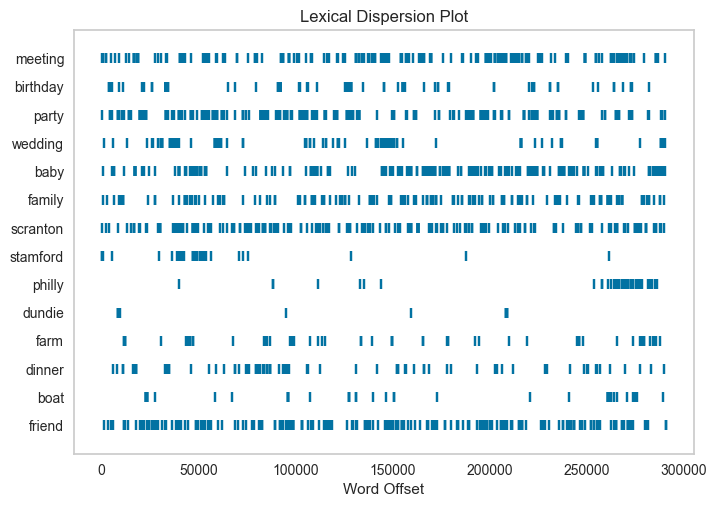

<AxesSubplot: title={'center': 'Lexical Dispersion Plot'}, xlabel='Word Offset'>

In [17]:
from yellowbrick.text import DispersionPlot

target_words = ['meeting', 'birthday', 'party', 'wedding', 'baby', 'family', 'scranton', 'stamford', 'philly', 'dundie', 'farm', 'dinner', 'boat', 'friend']
visualizer = DispersionPlot(target_words)
visualizer.fit([all_words])
visualizer.show()

In [18]:
nltk.Text(all_words).concordance('dundie', lines=5)

Displaying 5 of 16 matches:
 halpert jim_halpert take tour past dundie winners got fat jim_halpert jim sho
d say go lame stanley manly stanley dundie allstar stan ah show bling know thi
hink peering stalls pervert pervert dundie award longest engagement goes pam b
 time kind isthat kind like dundies dundie waitress tripped cord alright alrig
right joke landed thank coming 2005 dundie awards host michael_scott want tell


In [19]:
#find n-grams
finder_2 = nltk.collocations.BigramCollocationFinder.from_words(all_words)
finder_3 = nltk.collocations.TrigramCollocationFinder.from_words(all_words)
finder_4 = nltk.collocations.QuadgramCollocationFinder.from_words(all_words)

finder_3.ngram_fd.most_common(20)

[(('let', 'us', 'go'), 203),
 (('let', 'us', 'get'), 107),
 (('hey', 'hey', 'hey'), 78),
 (('whoa', 'whoa', 'whoa'), 63),
 (('oh', 'god', 'oh'), 59),
 (('na', 'na', 'na'), 55),
 (('let', 'us', 'see'), 52),
 (('go', 'go', 'go'), 49),
 (('one', 'two', 'three'), 45),
 (('stop', 'stop', 'stop'), 44),
 (('god', 'oh', 'god'), 41),
 (('come', 'let', 'us'), 39),
 (('blah', 'blah', 'blah'), 37),
 (('ha', 'ha', 'ha'), 35),
 (('okay', 'let', 'us'), 34),
 (('yes', 'yes', 'yes'), 33),
 (('wait', 'wait', 'wait'), 32),
 (('get', 'back', 'work'), 31),
 (('yeah', 'yeah', 'yeah'), 28),
 (('oh', 'oh', 'oh'), 28)]

In [20]:
# TODO: Document clustering/ Topic Modeling
# TODO: Sentiment Analysis (show how it evolves over time)
# TODO: also include network analysis

## Sentiment Analysis

In [21]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("All right Jim. Your quarterlies look very good. How are things at the library?")

{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4927}

In [51]:
# calculate sentiment scores for each line
df_sentiment = df_raw.copy()
df_sentiment["sentiment"] = df_raw["line_text"].apply(lambda x: sia.polarity_scores(x))

In [69]:
# visualize sentiment scores over time

# set id as column 
df_sentiment['id'] = df_sentiment.index

# set new row as numerical
df_sentiment['neg'] = df_sentiment['sentiment'].apply(lambda x: x['neg'])
df_sentiment['neu'] = df_sentiment['sentiment'].apply(lambda x: x['neu'])
df_sentiment['pos'] = df_sentiment['sentiment'].apply(lambda x: x['pos'])


In [ ]:
df_rolling = df_sentiment.rolling(5).mean()

In [79]:
# display sentiment over time for a given season and episode
px.line(df_rolling[(df_rolling["season"] == 5) & (df_rolling['episode'] == 16)], x="id", y=["neg", "neu", "pos"], title="Sentiment over time", color_discrete_sequence=px.colors.qualitative.Pastel)

In [25]:
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

sentence = Sentence('All right Jim. Your quarterlies look very good. How are things at the library?')
classifier.predict(sentence)

print('Sentiment: ', sentence.labels)

c:\Users\schla\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



2023-02-26 22:02:58,516 loading file C:\Users\schla\.flair\models\sentiment-en-mix-distillbert_4.pt
Sentiment:  ['Sentence: "All right Jim . Your quarterlies look very good . How are things at the library ?"'/'POSITIVE' (0.9984)]


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("All right Jim. Your quarterlies look very good. How are things at the library?")

{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4927}

In [27]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = "All right Jim. Your quarterlies look very good. How are things at the library?"
doc = nlp(text)
print(doc._.polarity)
print(doc._.subjectivity)
print(doc._.blob.sentiment_assessments.assessments)
print(doc._.blob.ngrams())

0.5978571428571429
0.6578571428571429
[(['right'], 0.2857142857142857, 0.5357142857142857, None), (['very', 'good'], 0.9099999999999999, 0.7800000000000001, None)]
[WordList(['All', 'right', 'Jim']), WordList(['right', 'Jim', 'Your']), WordList(['Jim', 'Your', 'quarterlies']), WordList(['Your', 'quarterlies', 'look']), WordList(['quarterlies', 'look', 'very']), WordList(['look', 'very', 'good']), WordList(['very', 'good', 'How']), WordList(['good', 'How', 'are']), WordList(['How', 'are', 'things']), WordList(['are', 'things', 'at']), WordList(['things', 'at', 'the']), WordList(['at', 'the', 'library'])]


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [ ]:
import torch

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

text = "You are the worst person ever!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = torch.softmax(output.logits, axis=1)

In [ ]:
# Tokenize the text and encode it as input features
encoded_data = tokenizer.batch_encode_plus(
    df_raw['line_text'].values.astype('str'),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = df['sentiment'].values

KeyError: 'sentiment'

## Network Analysis

In [ ]:
# create a list of the most important characters in the tv show the office
important_characters = ["Michael", "Dwight", "Jim", "Pam", "Ryan", "Andy", "Kevin", "Angela", "Phyllis", "Stanley", "Meredith", "Toby", "Oscar", "Kelly", "Creed"]

In [ ]:
speaker = df.groupby(['season', 'episode', 'scene'])['speaker'].apply(set).reset_index(name='speakers')

character_edges = {}
for c in speaker['speakers']:
    c = list(c)
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            character_tuple = (c[i], c[j])
            character_tuple_inv = (c[j], c[i])
            if character_tuple in character_edges:
                character_edges[character_tuple] += 1
            elif character_tuple_inv in character_edges:
                character_edges[character_tuple_inv] += 1
            else:
                character_edges[character_tuple] = 1

# only keep edges between important characters
character_edges = {k: v for k, v in character_edges.items() if k[0] in important_characters and k[1] in important_characters}

TypeError: 'list' object is not callable

In [ ]:
#pos = nx.spectral_layout(graph, weight='weight', scale=2, center=(0, 0))
#nx.draw(graph, pos, with_labels=True, node_size=[w/total_weights*30000 for w in node_weights], font_size=20,
#            edgelist=[(u, v) for (u, v, d) in graph.edges(data=True)],
#            width=[0.01*d['weight'] for (u, v, d) in graph.edges(data=True)])



In [ ]:
import networkx as nx
import plotly.graph_objects as go

graph = nx.Graph()
for character_tuple, count in character_edges.items():
    graph.add_edge(character_tuple[0], character_tuple[1], weight=count)


node_weights = [sum([d['weight'] for (u, v, d) in graph.edges(data=True) if u == node]) for node in graph.nodes()]
total_weights = sum(node_weights)
node_weights_normalized = (np.array(node_weights)/total_weights)*500
pos = nx.spring_layout(graph, weight='weight', k=3)

import igviz as ig

ig.plot(graph,
size_method=list(node_weights_normalized)
)

C:\Users\schla\AppData\Local\Temp\ipykernel_18844\864791407.py:16: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines',
              'text': [],
              'type': 'scatter',
              'uid': 'd998af2f-647b-4a3c-9688-083703689d99',
              'x': [0.5158489346504211, 0.8027080297470093, None, ...,
                    0.933087944984436, 0.37822648882865906, None],
              'y': [0.5060888528823853, 0.7763158082962036, None, ...,
                    0.10320699959993362, 0.32585400342941284, None]},
             {'hoverinfo': 'text',
              'hovertext': [Node: Michael<br>Degree: 14, Node: Jim<br>Degree: 14,
                            Node: Pam<br>Degree: 14, Node: Dwight<br>Degree: 14,
                            Node: Phyllis<br>Degree: 14, Node: Stanley<br>Degree:
                            14, Node: Kevin<br>Degree: 14, Node: Angela<br>Degree:
                            14, Node: Ryan<br>Degree: 14, Node: Oscar<br>Degree:
                       

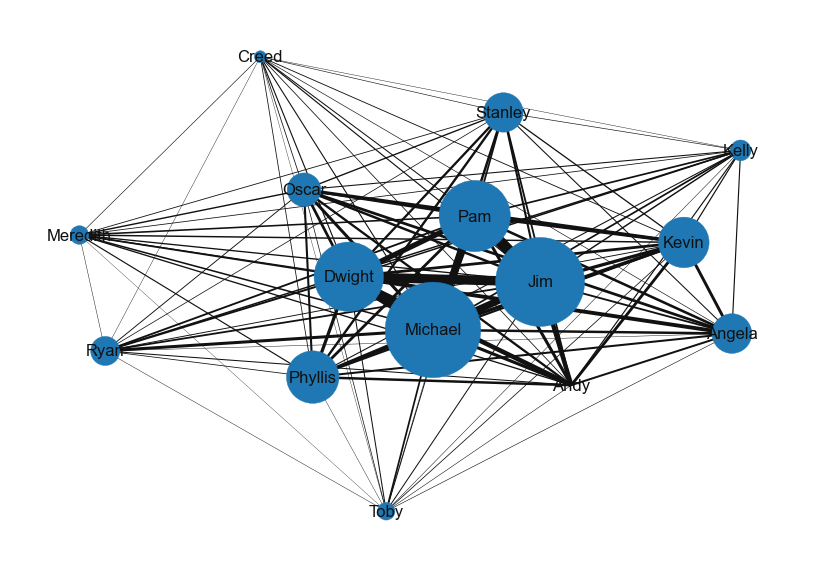

In [ ]:
import networkx as nx

graph = nx.Graph()
for character_tuple, count in character_edges.items():
    graph.add_edge(character_tuple[0], character_tuple[1], weight=count)
pos = nx.spring_layout(graph, k=100, iterations=500)
node_weights = [sum([d['weight'] for (u, v, d) in graph.edges(data=True) if u == node]) for node in graph.nodes()]
total_weights = sum(node_weights)
nx.draw(graph, pos, with_labels=True, node_size=[w/total_weights*20000 for w in node_weights], font_size=12,
            edgelist=[(u, v) for (u, v, d) in graph.edges(data=True)],
            width=[0.01*d['weight'] for (u, v, d) in graph.edges(data=True)])